# Microsoft (MSFT) Stock Forecasting using LSTM 

$\color{green} \textbf{Author: Devraj Katkoria}$ 

$\color{red} \textbf{Note: Please use this notebook to test your configuration of environments and python version in order to ensure compatibility with the main LSTM Framework}$

LSTM stands for Long Short Term Memory and is a type of Recurrent Neural Network (RNN) that is particularly useful for time series data, e.g. stock prices, weather forecasts, etc. 

In the case of Stock forecasting, there will be a training cycle to determine parameters that weight the impact of $k$-lag from current point, $x_0$ to the next stock price prediction, $x_1$. 

Since this project is aimed to utilize Metal on MacOS X for faster processing using the GPU, **TensorFlow** will be used for this project. If you have a Intel-Based Mac or Windows, please follow the configuration steps in the README.

## Gathering the Data 
We will be using Yahoo Finance to obtain our data we can either manually download the dataset from the [Yahoo Finance Webpage](https://finance.yahoo.com/quote/MSFT/history/) (PAID) or use the Yahoo Finance API to fetch stock price data. 

I will be downloading the *MSFT* dataset. 

In [1]:
import yfinance as yf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime

In [2]:
import os

# Function to fetch stock data for a ticker and save it to a CSV file
def fetch_stock_data(ticker, start_date, end_date):
    # Fetch the stock data
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    
    # Save the data to a CSV file
    csv_file = f"data/{ticker}_data.csv"
    stock_data.to_csv(csv_file)
    
    print(f"Stock data for {ticker} saved to {csv_file}")

    # Remove the top 3 lines and replace the top line with column headers
    with open(csv_file, 'r') as file:
        lines = file.readlines()[3:]  # Skip the first 3 lines

    # Replace the first line with the desired headers
    lines[0] = "Date,Open,High,Low,Close,Volume\n"

    # Write the modified lines back to the file
    with open(csv_file, 'w') as file:
        file.writelines(lines)

In [3]:
# Downloading MSFT Stock Data from 2000-01-01 to 2025-04-01
fetch_stock_data('MSFT', '2000-01-01', '2025-04-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Stock data for MSFT saved to data/MSFT_data.csv


In [4]:
# Create dataframe with the CSV file
df = pd.read_csv('data/MSFT_data.csv')
df.tail() # Preview the last few rows of the dataframe

,Date,Open,High,Low,Close,Volume
6343,2025-03-25,395.160004,396.359985,392.640015,393.920013,15775000
6344,2025-03-26,389.970001,395.309998,388.570007,395.000000,16108400
6345,2025-03-27,390.579987,392.239990,387.399994,390.130005,13766800
6346,2025-03-28,378.799988,389.130005,376.929993,388.079987,21632000
6347,2025-03-31,375.390015,377.070007,367.239990,372.540009,35184700


In [5]:
# Reduce dataframe to only 'Date' and 'Close' columns
df = df[['Date', 'Close']]
df.tail()

,Date,Close
6343,2025-03-25,393.920013
6344,2025-03-26,395.000000
6345,2025-03-27,390.130005
6346,2025-03-28,388.079987
6347,2025-03-31,372.540009


In [6]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.tail() # Visually Unchanged 

,Date,Close
6343,2025-03-25,393.920013
6344,2025-03-26,395.000000
6345,2025-03-27,390.130005
6346,2025-03-28,388.079987
6347,2025-03-31,372.540009


In [7]:
# Shift Date column to be the index column
df.index = df.pop('Date')
df.tail()

,Close
Date,
2025-03-25,393.920013
2025-03-26,395.000000
2025-03-27,390.130005
2025-03-28,388.079987
2025-03-31,372.540009


## Visualizing Data 
We can now plot our stock price data just to make sure that any modifications haven't been incorrectly applied

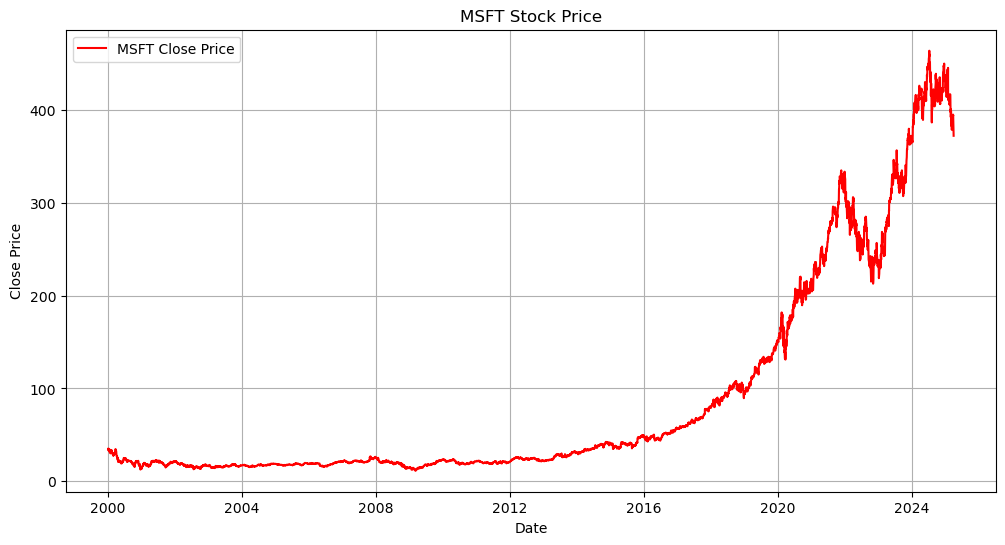

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='MSFT Close Price', color='red')
plt.title('MSFT Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

## Conversion to Supervised Learning Problem

In [8]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

In [9]:
# Preview head and tail to find bounds for window function
df.head(3)


,Close
Date,
2000-01-04,34.871114
2000-01-05,34.122634
2000-01-06,34.448897


In [10]:
df.tail(3)

,Close
Date,
2025-03-27,390.130005
2025-03-28,388.079987
2025-03-31,372.540009


In [11]:
windowed_df = df_to_windowed_df(df, 
                                '2023-03-25', 
                                '2025-03-31', 
                                n=10)
windowed_df

,Target Date,Target-10,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2023-03-25,247.149189,243.526818,252.730424,255.909881,261.057951,273.903693,272.643745,270.576590,269.119769,273.588665,272.899637
1,2023-03-28,252.730424,255.909881,261.057951,273.903693,272.643745,270.576590,269.119769,273.588665,272.899637,276.108626,271.472312
2,2023-03-29,255.909881,261.057951,273.903693,272.643745,270.576590,269.119769,273.588665,272.899637,276.108626,271.472312,274.592717
3,2023-03-30,261.057951,273.903693,272.643745,270.576590,269.119769,273.588665,272.899637,276.108626,271.472312,274.592717,279.780232
4,2023-03-31,273.903693,272.643745,270.576590,269.119769,273.588665,272.899637,276.108626,271.472312,274.592717,279.780232,279.288008
...,...,...,...,...,...,...,...,...,...,...,...,...
500,2025-03-25,379.000000,382.950012,383.160004,379.779999,386.700012,387.070007,385.529999,385.739990,383.220001,395.399994,393.920013
501,2025-03-26,382.950012,383.160004,379.779999,386.700012,387.070007,385.529999,385.739990,383.220001,395.399994,393.920013,395.000000
502,2025-03-27,383.160004,379.779999,386.700012,387.070007,385.529999,385.739990,383.220001,395.399994,393.920013,395.000000,390.130005
503,2025-03-28,379.779999,386.700012,387.070007,385.529999,385.739990,383.220001,395.399994,393.920013,395.000000,390.130005,388.079987


In [12]:
# Convert to Numpy Array 
def windowed_df_to_numpy(windowed_df):
    df_as_numpy = windowed_df.to_numpy()
    dates = df_as_numpy[:, 0]

    middle_matrix = df_as_numpy[:, 1:-1]
    X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1)

    Y = df_as_numpy[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

In [13]:
dates, X, Y = windowed_df_to_numpy(windowed_df)
dates.shape, X.shape, Y.shape

((505,), (505, 10, 1), (505,))

## Splitting Training Data (Train/Validation/Test Split)

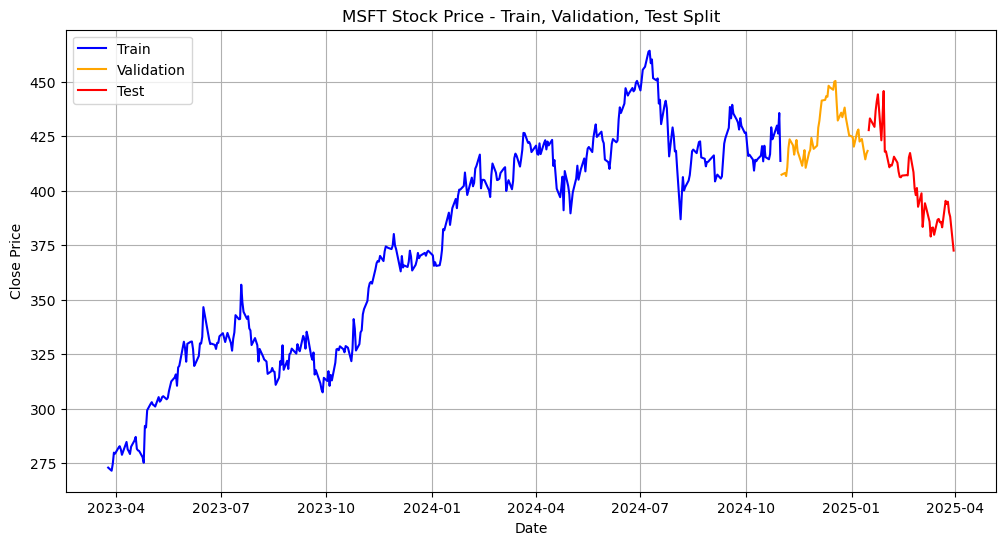

In [14]:
q_80 = int(len(dates) * 0.8) # 80% for training
q_90 = int(len(dates) * 0.9) # 10% for validation

dates_train, X_train, Y_train = dates[:q_80], X[:q_80], Y[:q_80]
dates_val, X_val, Y_val = dates[q_80:q_90], X[q_80:q_90], Y[q_80:q_90]
dates_test, X_test, Y_test = dates[q_90:], X[q_90:], Y[q_90:]

# Visualize the splits 
plt.figure(figsize=(12, 6))
plt.plot(dates_train, Y_train, label='Train', color='blue')
plt.plot(dates_val, Y_val, label='Validation', color='orange')
plt.plot(dates_test, Y_test, label='Test', color='red')
plt.title('MSFT Stock Price - Train, Validation, Test Split')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

## Model Development & Training

In [15]:
import tensorflow as tf
# tf.config.set_visible_devices([], 'GPU') # Uncomment if GPU support not working

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import layers

In [16]:
# Testing block for Metal
gpu_devices = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpu_devices)

# Run a simple operation to see where it's executed:
a = tf.constant([[1.0, 2.0]])
b = tf.constant([[3.0], [4.0]])
c = tf.matmul(a, b)
print(c)

if gpu_devices:
    # Adjust the device string from '/physical_device:GPU:0' to 'GPU:0'
    device_str = gpu_devices[0].name.split(":")[-2] + ":" + gpu_devices[0].name.split(":")[-1]
    try:
        memory_info = tf.config.experimental.get_memory_info(device_str)
        print("Memory Info:", memory_info)
    except Exception as e:
        print("Memory info not available:", e)
else:
    print("No GPUs detected.")

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.Tensor([[11.]], shape=(1, 1), dtype=float32)
Memory Info: {'current': 0, 'peak': 0}


2025-04-06 20:50:40.844454: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-04-06 20:50:40.844523: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-06 20:50:40.844532: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-04-06 20:50:40.844725: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-06 20:50:40.844744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


You should see an output like below if working on an Apple Silicon Mac with proper GPU Utilization:
```
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.Tensor([[11.]], shape=(1, 1), dtype=float32)
Memory Info: {'current': 0, 'peak': 0}
2025-04-06 13:06:51.627702: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-04-06 13:06:51.627727: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-06 13:06:51.627731: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-04-06 13:06:51.627750: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-06 13:06:51.627759: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
```

In [17]:
model = Sequential([layers.Input((3, 1)), 
                    layers.LSTM(64), 
                    layers.Dense(32, activation='relu'), 
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['mae'])
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=150, batch_size=32, verbose=1)

Epoch 1/150


2025-04-06 20:50:57.869617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 144668.1719 - mae: 377.2813 - val_loss: 180899.1250 - val_mae: 425.1512
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 141234.2500 - mae: 372.6684 - val_loss: 179675.9375 - val_mae: 423.7102
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 140120.1562 - mae: 371.1409 - val_loss: 178266.6406 - val_mae: 422.0440
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 140275.3438 - mae: 371.1588 - val_loss: 176570.2344 - val_mae: 420.0294
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 134841.8125 - mae: 363.8253 - val_loss: 173760.2344 - val_mae: 416.6709
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 135569.3125 - mae: 364.7654 - val_loss: 170048.9062 - val_mae: 412.1934
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 131628.6562 - mae: 359.4709 - val_loss: 164923.5000 - val_mae: 405.9283
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 126551.1797 - mae: 352.2587 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


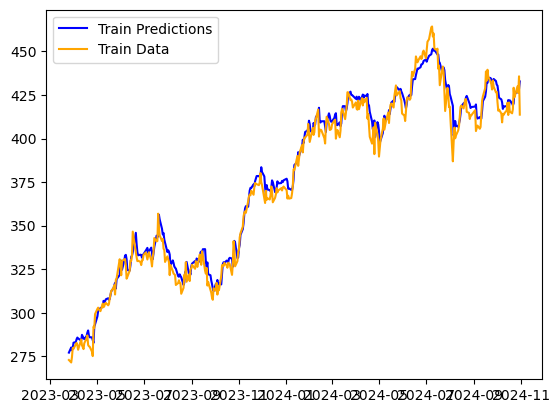

In [18]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions, label='Train Predictions', color='blue')
plt.plot(dates_train, Y_train, label='Train Data', color='orange')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


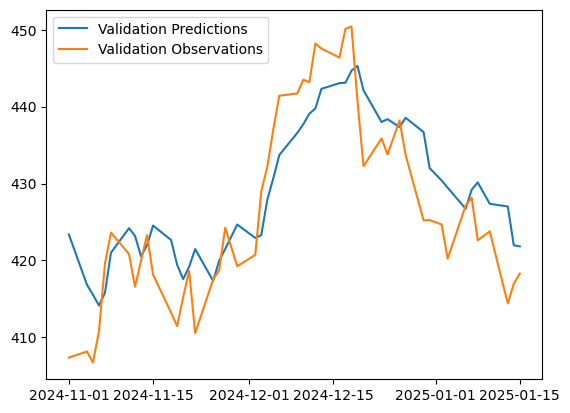

In [19]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


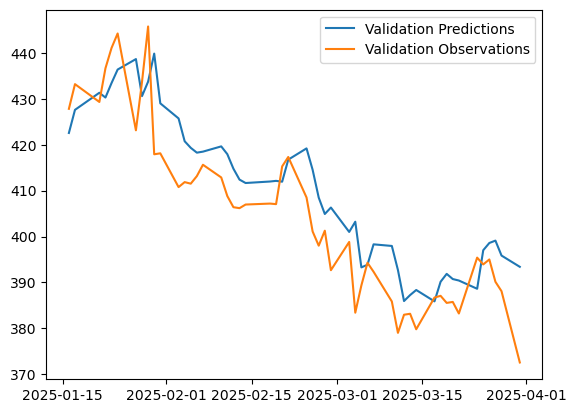

In [20]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(['Validation Predictions', 'Validation Observations'])

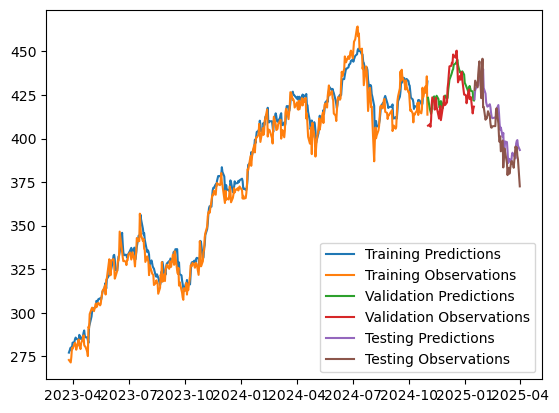

In [21]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [22]:
from copy import deepcopy 

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
    last_window = deepcopy(X_train[-1])
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

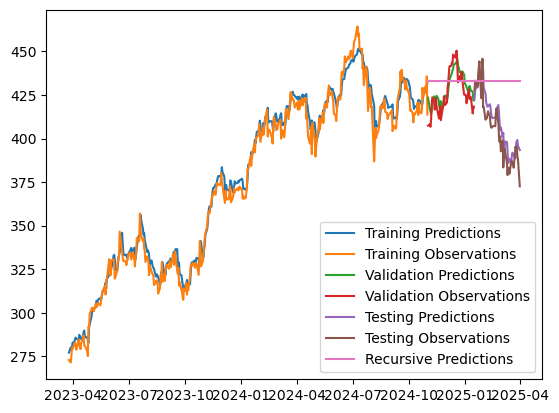

In [23]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations', 
            'Recursive Predictions'])
plt.show()